# Case Study 2: Descriptive Data Mining
## CAB330: Assignment 2

### Table of content
1. [Descriptive Data Mining - Clustering](#clustering)
2. [Descriptive Data Mining - Association](#association)
3. [Text Mining](#text)
4. [Web Mining](#web)

In [82]:
%matplotlib inline
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import datetime
import numpy as np
from apyori import apriori
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from scipy.spatial.distance import euclidean
from math import sqrt

## Download nltk package
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

import warnings     
warnings.filterwarnings("ignore")

# Task 1. Descriptive Data Mining - Clustering<a name="clustering"></a>

## 1. Can you identify data quality issues in this dataset such as unusual data types,missing values, or very skewed attributes?
The dataset does not contain any unusual data types. There are also no missing values in the dataset. However, high positive or negative skewness and kurtosis values could be seen in FFMC, ISI, rain, and area columns. Those variables are very skewed toward 0, therefore it is ideal to preprocess data with the logarithm transformation. 

Number of mising values:  0


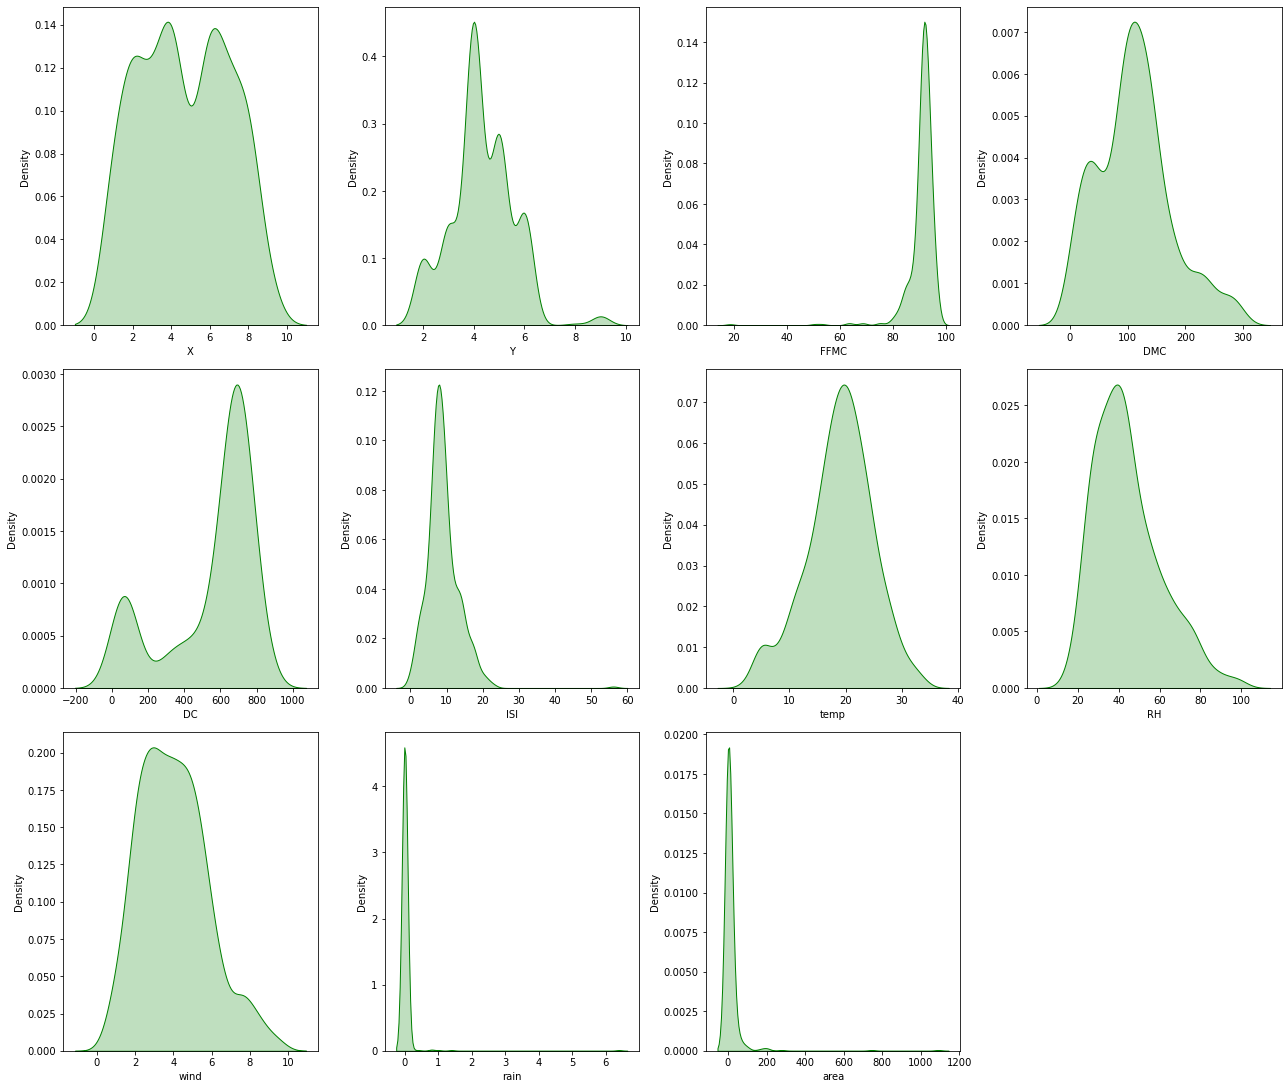

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344,12.846934
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964,194.140721


In [3]:
df = pd.read_csv('forestfires.csv', na_filter=False)

print('Number of mising values: ', df.isna().sum().sum()) 

num_columns = df.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
  
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

## 2. Which variables were included in your analysis and what were their roles and measurement level set? Justify your choice.

The variables included in the analysis are `temp`, `RH`, `wind`, `rain` and `area`. `area` is selected to see if there exists any clusters that could provide key characteristics of the small fire. The measurement level of `area` is the ratio scale.  `RH`, `temp`, `wind`, and `rain` are also the variables of interest. The study on the forest fire data set has shown that those four weather attributes are probably capable of foreseeing minor fires. Determine the combination of those attributes which can lead to small fire is also the requirement of this analysis. The measurement level of four variables is the ratio scale. However, due to the high positive skewness of the `rain` column (most of the values in `rain` are 0), we can convert it as a categorical column.

## 3. Build a default clustering model with K=3

Cluster membership
0    180
1     88
2      2
Name: Cluster_ID, dtype: int64


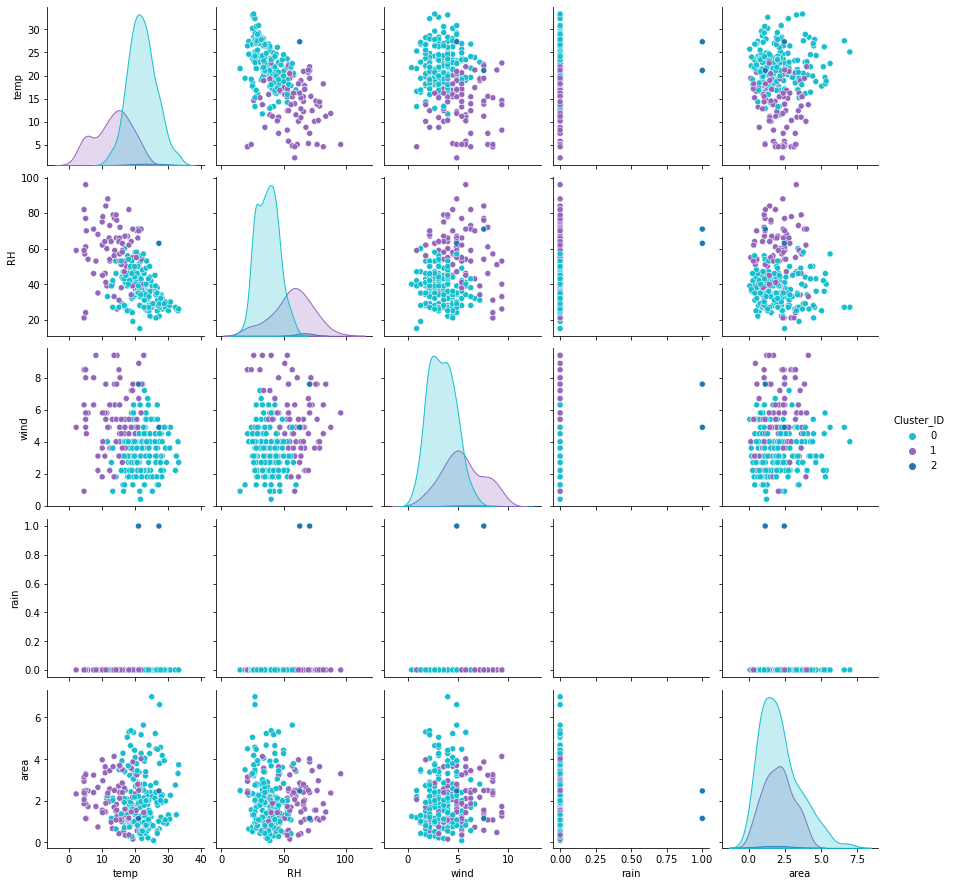

In [4]:
# The variables of interest
columns =['temp', 'RH', 'wind', 'rain', 'area']
df = df[columns]

# Only select the row that has fire area > 0
df = df[df['area']  > 0]

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df_log = df.copy()

# Apply log transform to area column
columns_to_log_transform = ['area']

for col in columns_to_log_transform:
    df_log[col] = df_log[col].apply(lambda x: x + 1)
    df_log[col] = df_log[col].apply(np.log)
    

# Convert data frame to matrix
X = df_log.values

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set the random state. different random state seeds might result in different centroids locations
rs = 42
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)

# Sssign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df_log['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_log['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_log, hue='Cluster_ID', palette="tab10_r")
plt.show() 

The number of members in clusters 0, 1, and 2 is 180, 88, and 2 respectively. The `pairplot` shows some interesting insights:
* Look at the `rain` plot, we could see the clear difference between cluster 2 and the other two clusters. Cluster 2 covers the fire break out on rainy days, while clusters 0 and 1 cover the fire in the area without rain.
* Take `area` distribution as an example, the burned area of the forest in cluster 1 is smaller than cluster 0.
* For `wind` and `RH`, the fire in cluster 1 generally has average large values of relative humidity and wind speed, while cluster 0 has the smaller ones.
* In terms of `temp`, `pairplot` indicates that cluster 0 covers the fire with higher temperature. 

The key characteristics of each cluster can be described as follow:
* Cluster 0: The larger fire with low wind speed, low relative humidity, and high temperature
* Cluster 1: The average smaller fire with high wind speed, high relative humidity, and low temperature
* Cluster 2: The fire breaks out in rainy weather conditions.

## 4. What is the effect of using the standardization method on the model above? Does the variable normalization process enable a better clustering solution?

Cluster membership
0    256
2     12
1      2
Name: Cluster_ID, dtype: int64


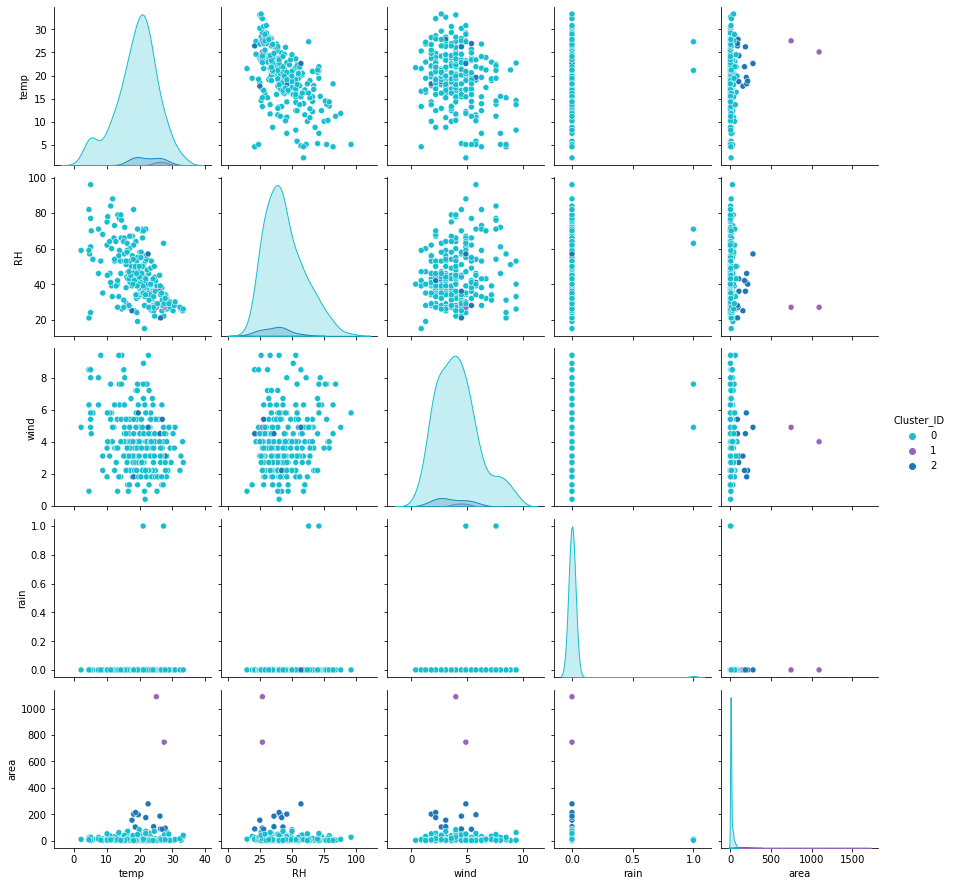

In [5]:
df_log = df.copy()

# Convert data frame to matrix
X = df_log.values

# Set the random state. different random state seeds might result in different centroids locations
rs = 42
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)

# Sssign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df_log['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_log['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_log, hue='Cluster_ID', palette="tab10_r")
plt.show() 

The K-means clustering is greatly affected by variables on a different scale. It is mainly because that clustering uses Euclidean distance, which favors attributes on a larger scale instead of the smaller ones. As we can see from the example of implementing K-means clustering without the standardization method, the fire is mainly clustered based on their area value: cluster 0 with the small burned area, cluster 2 with the average burned area, and cluster 1 with the large burned area. The standardization helps the K-means model consider all five variables and enable a better clustering solution.

## 5. Using elbow method and silhouette, find the optimal K. What is the best K?

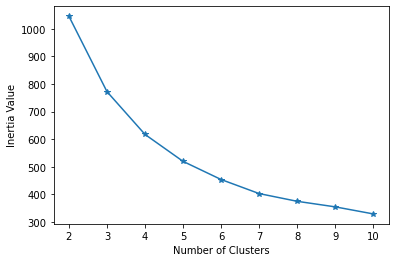

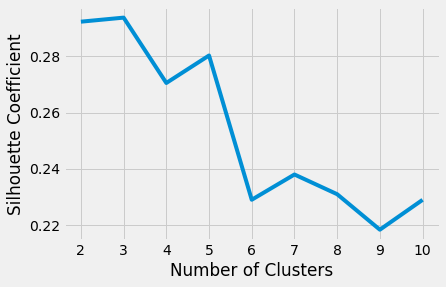

In [6]:
df_log = df.copy()

# Apply log transform to area column
columns_to_log_transform = ['area']

for col in columns_to_log_transform:
    df_log[col] = df_log[col].apply(lambda x: x + 1)
    df_log[col] = df_log[col].apply(np.log)
    

# Convert data frame to matrix
X = df_log.values

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set the random state. different random state seeds might result in different centroids locations
rs = 42

# list to save the clusters and cost
clusters = []
inertia_vals = []
silhouette_coefficients = []


# this whole process should take a while
for k in range(2, 11):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    silhouette_coefficients.append(score)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

plt.plot(range(2,11), inertia_vals, marker='*')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Value")
plt.show()



# A list holds the silhouette coefficients for each k  
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Looking at the plot showing inertia and K values, the elbow is somewhere between 4 and 5. The silhouette score is now used to determine the optimal K between those two values. The higher the silhouette score is, the better quality the cluster is. `silhouette_score` returns a mean silhouette score of 0.27 for $K=4$ and 0.28 for $K=5$. This result suggests that $K=5$ should be selected because the object in the cluster with $K=5$ is better matched to its cluster.

Cluster membership
1    133
0     59
4     43
3     33
2      2
Name: Cluster_ID, dtype: int64


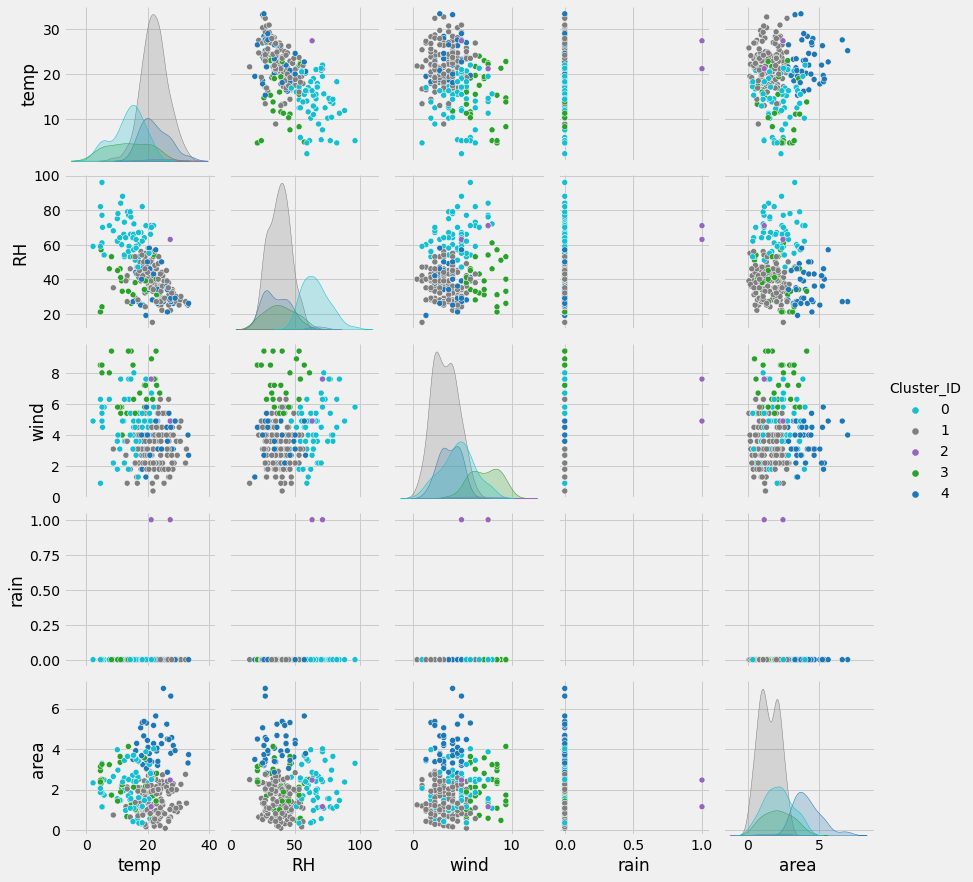

In [7]:
# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=5, random_state=rs)
model.fit(X)

# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df_log['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_log['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_log, hue='Cluster_ID', palette="tab10_r")
plt.show() 

## 6. How the outcome of this study can be used by decision makers?

Using the clustering model with optimal $K=5$, cluster 1 covers the small fire and it is the cluster of interest. The key characteristics of cluster 1 are no rain, average low wind speed and relative humidity, and high temperature. The  Bureau of Meteorology could set up some sensors to measure the four weather condition attributes. If the measurement is well-matched with the properties of cluster 1, the warning about the small fire would be announced to the residents.

# Task 2. Descriptive Data Mining - Association <a name="association"></a>

## 1. Can you identify data quality issues in this dataset for performing association analysis?
The quantity variable is all equal to 1. Instead of having the quantity increase for multiple purchases of an item, they just add the same item as a transaction with the quantity of 1. 

In [8]:
# load the bank transaction dataset
df = pd.read_csv('retail_row.csv')
df.describe()

,LOC,TRANS_ID,QUANTITY
count,459223.000000,4.592230e+05,459223.0
mean,5.490999,6.180346e+05,1.0
std,2.867294,3.511314e+05,0.0
min,1.000000,1.257200e+04,1.0
25%,3.000000,3.125300e+05,1.0
50%,5.000000,6.168770e+05,1.0
75%,8.000000,9.254480e+05,1.0
max,10.000000,1.221866e+06,1.0


## 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
The variables used were `TRANS_ID` and `PRODUCT`. The measurement level of two variables is the nominal scale. The products were grouped by their transaction ID to create the "transactions". Then each transaction (the list of all of the products in each transaction) was converted into a set to remove duplicate values. As we understand association mining, we mainly care about if someone buys at least 1 of x, then what is the probability of them buying at least 1 of y. Adding in each transaction where people are buying multiple products could lead to many more associations with very few occurrences because of the rarity. As a result, converting the lists to a set was chosen.

## 3. Conduct association mining

In [9]:
# group by transaction ID then list all the products. Note that the set function was used instead of list to remove duplicates.
transactions = df.groupby(['TRANS_ID'])['PRODUCT'].apply(set)

# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.005))

def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

#### a) What is the highest lift value for the resulting rules? Which rule has this value?
People who buy sugar also buy cheese. This has a lift of 8.213091

In [10]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(10))

           Left_side       Right_side   Support  Confidence      Lift
52             Sugar           Cheese  0.006076    0.119141  8.213091
51            Cheese            Sugar  0.006076    0.418821  8.213091
131  Tea,Conditioner           Butter  0.006491    0.377545  5.605241
126           Butter  Tea,Conditioner  0.006491    0.096362  5.605241
127      Conditioner       Tea,Butter  0.006491    0.072143  5.475297
130       Tea,Butter      Conditioner  0.006491    0.492600  5.475297
214      Shampoo,Egg      Tea,Yoghurt  0.005820    0.181421  4.476398
219      Tea,Yoghurt      Shampoo,Egg  0.005820    0.143615  4.476398
217      Shampoo,Tea      Egg,Yoghurt  0.005820    0.183799  4.209908
216      Egg,Yoghurt      Shampoo,Tea  0.005820    0.133318  4.209908


#### b) What is the highest confidence value for the resulting rules? Which rule has this value?
People who buy butter and tea, also buy conditioner. This has a confidence of 0.4296

In [84]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(10))

                 Left_side   Right_side   Support  Confidence      Lift
130             Tea,Butter  Conditioner  0.006491    0.492600  5.475297
220        Shampoo,Egg,Tea      Yoghurt  0.005820    0.487233  2.849408
164        Shampoo,Cordial      Yoghurt  0.011391    0.463762  2.712146
192                Egg,Tea      Yoghurt  0.016661    0.458574  2.681806
221    Shampoo,Egg,Yoghurt          Tea  0.005820    0.441746  1.830611
206            Shampoo,Tea      Yoghurt  0.013721    0.433286  2.533917
223    Shampoo,Tea,Yoghurt          Egg  0.005820    0.424198  2.887913
51                  Cheese        Sugar  0.006076    0.418821  8.213091
200  Yoghurt,Peanut butter          Tea  0.005110    0.416633  1.726542
194            Tea,Yoghurt          Egg  0.016661    0.411104  2.798770


#### c) Plot the confidence, lift, and support of the resulting rules. Interpret them to discuss the rule-set obtained.

<AxesSubplot:xlabel='Support', ylabel='Lift'>

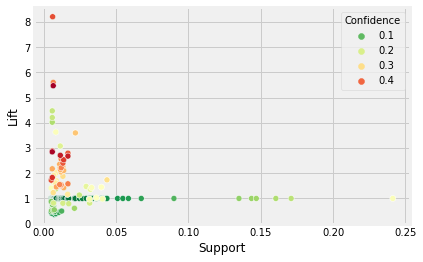

In [110]:
result_df = result_df.sort_values(by='Confidence', ascending=True)
sns.scatterplot(x="Support", y="Lift", data=result_df, hue="Confidence", palette="RdYlGn_r")

The set of rules that have lift value greater than 1 are of interest. The rules that have high lift value also have high confidence value. However, the confidence values of those rule are smaller than 0.05. 

## 4. The store is particularly interested in products that individuals purchase when they buy “Yoghurt”

#### a) How many rules are in the subset? 
There are 15 rules in this subset

In [111]:
# Rules in the dataset
yog_df = result_df.loc[result_df['Left_side'] == 'Yoghurt'].sort_values(by='Lift', ascending=False)
print("Number of rules in this subset", yog_df.shape[0])

Number of rules in this subset 15


#### b) Based on the rules, what are the other products these individuals are most likely to purchase?
Egg, tea, shampoo and cordial.

In [14]:
yog_df.sort_values(by='Lift', ascending=False)

,Left_side,Right_side,Support,Confidence,Lift
213,Yoghurt,"Shampoo,Egg,Tea",0.005820,0.034039,2.849408
163,Yoghurt,"Shampoo,Cordial",0.011391,0.066616,2.712146
191,Yoghurt,"Egg,Tea",0.016661,0.097438,2.681806
205,Yoghurt,"Shampoo,Tea",0.013721,0.080243,2.533917
184,Yoghurt,"Shampoo,Egg",0.013176,0.077056,2.401784
170,Yoghurt,"Tea,Cordial",0.012001,0.070184,2.219057
97,Yoghurt,Egg,0.043659,0.255322,1.738217
149,Yoghurt,"Egg,Cordial",0.008096,0.047345,1.619039
118,Yoghurt,Shampoo,0.039783,0.232659,1.450232
85,Yoghurt,Cordial,0.033013,0.193064,1.430826


### 5. How the outcome of this study can be used by decision makers?
* Put them closer together in the store.
* Package the items together with another poorly selling item.
* Raising the price on one then lowering the price on another.
* Don't advertise these items together.
* Include smaller items as a gift to enhance customer satisfaction. (e.g. buy 2 shampoo get 1 cup of yoghurt)

# Task 3. Text Mining <a name="text"></a>

In [52]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
nums = set(string.digits)
stopwords = sw.words('english')

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # If a number, ignore token and continue
            if all(char in nums for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens


# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]

    words = []
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :num_word]:
            print(terms[term_idx], end=', ')
            words.append(terms[term_idx])

        print()
    
    # print(f"Number of duplicate words in the top list: {len(words) - len(set(words))}")
    seen = set()
    uniq = [x for x in words if x in seen or seen.add(x)]    
    print(f"List of repeated words: {set(uniq)}")
        

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(document_col)
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms

# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()

## 1. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice

Clustering is done purely with the `benefitsReview` variable. The variable `urlDrugName` can be used for recovering what drugs are in each of the clusters. The measurement level set of those variables is a nominal scale.

In [53]:
df = pd.read_csv('drugReview.csv')
terms = calculate_tf_idf_terms(df['benefitsReview'])

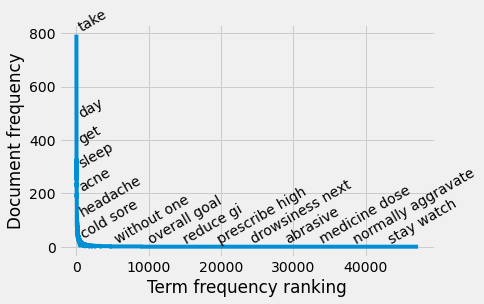

In [54]:
visualise_zipf(terms, 1)

## 2. Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.
Terms that are too common: `take`, `day`, `get`. Terms that are too uncommon: `stay watch`, `normally aggravate`, `medicine dose`, `abrasive`, `drowsiness next`, `prescribe high`, `reduce gi`.

## 3. Did you disregard any frequent terms? Justify their selection

When fitting some example clustering and looking at the top terms in each cluster, it was identified that some terms were being combined into clusters that had no clear meaning behind their combination. To limit these clusters from being created, a list of words was added to the nltk `stopwords`. The nltk `stopwords` were used in the beginning because they are generally useful terms that don't differentiate any of the benefits that we were looking for. Also, some clusters had numbers in them. Numbers were not a benefit or side effect, so they were removed (the removal is in the `cab_tokenizer` function where it passes on numeric characters). The full list of terms that were added to the `stopwords` can be seen below.

In [76]:
stop_array = ['take','feel', 'good', 'bad', 'stop', 'day', 'much', 'like', 'get', 'take', 'go', 'able', 'use', 'work', 'hour', 'would', ' drug', 'yet', 'week', 'month', 'start', 'time', 'none', 'within', 'help', 'benefit',
'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first', 'one']

## 4. Justify the term weighting option selected

TF-IDF was used because if a word was very frequent in a particular document, we would want it to have a higher weight for that document. But, if the word is present in a bunch of other documents, it is probably just a common word so we want to reduce the weighting. This helps find more relevant clusters.

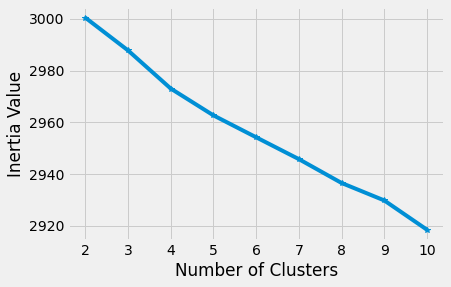

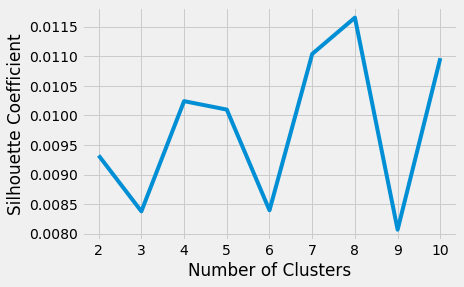

7952


In [77]:

stopwords = set(stop_array).union(set(sw.words('english')))
# stopwords = sw.words('english')

# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df['benefitsReview'])

# list to save the clusters and cost
clusters = []
inertia_vals = []
silhouette_coefficients = []


# this whole process should take a while
for k in range(2, 11):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X_filter)
    score = silhouette_score(X_filter, model.labels_)
    silhouette_coefficients.append(score)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

plt.plot(range(2, 11), inertia_vals, marker='*')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Value")
plt.show()



# A list holds the silhouette coefficients for each k  
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

In [78]:
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=8, random_state=rs).fit(X_filter)
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names(), 10)

Top terms for cluster 0: sleep, anxiety, night, depression, help, asleep, take, hot, attack, flash, 
Top terms for cluster 1: take, drug, symptom, treatment, benefit, year, reduce, control, headache, hair, 
Top terms for cluster 2: weight, energy, increase, loss, weight loss, lose, appetite, gain, depression, increase energy, 
Top terms for cluster 3: infection, clear, sinus, sinus infection, infection clear, day, antibiotic, yeast, yeast infection, treatment, 
Top terms for cluster 4: blood, blood pressure, pressure, lower blood, lower, low, low blood, reduce blood, high, high blood, 
Top terms for cluster 5: effect, side effect, side, take, drug, benefit, depression, treatment, without, seem, 
Top terms for cluster 6: skin, acne, clear, reduce, face, use, look, treatment, breakout, pimple, 
Top terms for cluster 7: pain, relief, reduce, take, pain relief, relieve, joint, reduce pain, help, drug, 
List of repeated words: {'take', 'benefit', 'reduce', 'depression', 'clear', 'help', 'tr

In [79]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

svd_kmeans = KMeans(n_clusters=8, random_state=rs).fit(X_trans)

# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names(), 10)

Top terms for cluster 0: hair, loss, hair loss, weight, weight loss, growth, lose, stop, hair growth, energy, 
Top terms for cluster 1: hot, flash, hot flash, sweat, night sweat, night, vaginal, sleep, flash night, decrease hot, 
Top terms for cluster 2: take, sleep, drug, depression, anxiety, symptom, help, treatment, benefit, also, 
Top terms for cluster 3: skin, acne, clear, reduce, use, clear acne, face, treatment, look, wrinkle, 
Top terms for cluster 4: pressure, blood, blood pressure, lower, lower blood, low blood, low, high, reduce blood, reduce, 
Top terms for cluster 5: pain, headache, relief, migraine, reduce, take, pain relief, relieve, reduce pain, help, 
Top terms for cluster 6: infection, clear, sinus, infection clear, sinus infection, day, antibiotic, treatment, ear, yeast, 
Top terms for cluster 7: effect, side, side effect, drug, take, benefit, depression, treatment, without, help, 
List of repeated words: {'take', 'benefit', 'reduce', 'depression', 'clear', 'help', '

## 5.  What is the number of input features available to execute clustering?
7952 features were used. A feature selection algorithm (SVD) was tested for performance. The reduction in size for the vector-space representation mostly came from limiting terms in `TfidfVectorizer` adding in extra `stopwords`.

## 6. State how many clusters are generated? Name each cluster meaningfully according to the terms that appear in the clusters?
8 clusters were fitted because the plot of the elbow method and silhouette score indicated that 8 is the optimal K value. The results obtained by SVD-transformed feature are not significantly different from those obtained by normal feature. As for the meaning of each cluster retrieved by original clustering solution:  
Cluster 0 - Sleep problems
Cluster 1 - Headaches problems
Cluster 2 - Obesity and Weight problems
Cluster 3 - Infection problems
Cluster 4 - Blood pressure problems
Cluster 5 - Benefit and Side effects 
Cluster 6 - Skin and facial problems
Cluster 7 - Pain relief problems

## 7. Identify the first six high frequent terms (that are not stop words) in the start list?
The six high frequent terms that are not stop words in the start list are 
`pain`, `effect`, `also`, `sleep`, `year`, `skin`

In [70]:

stop_array = [
    'take','feel', 'good', 'bad', 'stop', 'day', 'much', 'like', 'get', 'take', 'go', 'able', 'use', 
    'work', 'hour', 'would','drug', 'yet', 'week', 'month', 'start', 'time', 'none', 'start','within', 
    'help', 'benefit', 'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first','one'
    ]
term_df = pd.DataFrame(terms)
term_df.head(15)

hf_term = term_df['term'].head(17)
top_six = []

for term in hf_term:
    if term not in stop_array:
        top_six.append(term)
print(top_six)


['pain', 'effect', 'also', 'sleep', 'year', 'skin']


## 8. Describe how these clusters can be useful in the online service for recommending drugs based on their actual benefits to patients
For each cluster, it can determine what drug reviews represent most. Then they can have the related terms assigned to them. The example below shows how to get the most common drugs in cluster 4 (Blood pressure problems). They are recommended as the drugs to treat blood pressure problems. The result from the analysis is well-matched to the information we retrieve from the Internet. They both indicate that Prinivil, Hyzaar, and Norvasc are well-known products for treating high blood pressure problems.

In [81]:
cluster_map = pd.DataFrame()
cluster_map['drug'] = df['urlDrugName']
cluster_map['cluster'] = kmeans_fil.labels_
cluster_map[cluster_map['cluster'] == 4]['drug'].value_counts()

prinivil                      10
hyzaar                         5
norvasc                        5
micardis                       4
vasotec                        4
cozaar                         3
tenormin                       3
metformin                      3
diovan                         3
benicar                        2
hydrochlorothiazide            2
sular                          2
atacand                        1
tarka                          1
caduet                         1
singulair                      1
metformin-extended-release     1
catapres                       1
inspra                         1
spironolactone                 1
crestor                        1
zestoretic                     1
atenolol                       1
accupril                       1
paxil                          1
benicar-hct                    1
enalapril                      1
plendil                        1
niaspan                        1
lopressor                      1
diltiazem 

# Task 4. Web Mining <a name="web"></a>

## 1. Pre-process the log data to identify useful attributes based on columns in the text 
In the pre-processing stage, we are removing the accessorial entries such as embedded objects, graphics, font, sound files, and removing references due to spider navigation. Moreover, all entries with a status code other than 200 are removed. The data cleaning process could significantly reduce the storage space and increase the efficiency of data mining operations.


In [ ]:
# set names of pandas dataframe
names=['Host', 'Identd', 'Authuser', 'Date and time', 'Timezone', 'Request',
       'Status code', 'Bytes Sent', 'Referrer', 'Agent']
# read the dataframe
df = pd.read_csv('server_logs_raw.txt', sep=' ', names=names, header=None)

def extract_method_and_protocol(row):
    # function to extract HTTP request method and protocol from a request string
    request_splits = row['Request'].split()  # split request string by space
    row['Method'] = request_splits[0]
    row['Protocol'] = request_splits[-1]
    row['Request'] = ' '.join(request_splits[1:-1])  # stitch remaining request string back
    return row

df = df.apply(extract_method_and_protocol, axis=1)

# correct the incorrect dataframe types
df['Status code'] = df['Status code'].astype(int)  # set status code to int
df['Datetime'] = pd.to_datetime(df['Date and time'], format='[%d/%b/%Y:%H:%M:%S')  # set date time to pandas datatime obj
df = df.drop(['Date and time'], axis=1)

# list of IP addresses of spiders
spider_ip_list = []
for index, row in df.iterrows():
    if row['Request'].find('robots.txt') != -1:
        if row['Host'] not in spider_ip_list:
            spider_ip_list.append(row['Host'])

print("# Rows before:", len(df))

# create a mask to filter all images
mask = (df['Request'].str.endswith('.gif') | df['Request'].str.endswith('.jpg') | df['Request'].str.endswith('.jpeg') | df['Request'].str.endswith('.png') | df['Request'].str.endswith('.svg') | df['Request'].str.endswith('.ico') | df['Request'].str.endswith('.css')  | df['Request'].str.endswith('.ttf') | df['Request'].str.endswith('.js') )

# invert the mask, only keep records without .gif, .jpg .jpeg .png .svg .ico .css .js .tff in the request column
df2 = df[~mask]

# remove references due to spider navigation
df2 = df2[~df2['Host'].isin(spider_ip_list)]

print("After requests relating to non-analysed removal", len(df2))

# remove all unsuccessful requests (code != 200)
df2 = df2[df2['Status code'] == 200]

# only keep records with GET method
df2 = df2[df2['Method'].str.contains('GET')]

print("After invalid requests removal", len(df2))


# Rows before: 9999
After requests relating to non-analysed removal 3236
After invalid requests removal 2889


In [ ]:
# first, make a copy of df2 just in case
df3 = df2.copy()

# sort the rows based on datetime, descending
df3.sort_values(by='Datetime', inplace=True)

# initiate session ID and user ID to 0
session_id = 0
user_id = 0

# create a dictionaries to hold last access information
last_access = defaultdict(lambda:datetime.datetime.utcfromtimestamp(0))

# dictionary to find previous session, user ID and steps assigned to a specific date/ip/browser key
session_dict = defaultdict(lambda:1)
user_id_dict = defaultdict(lambda:1)
session_steps = defaultdict(lambda:1)

# function to be applied row wise
# for each row, produce session, user ID and path traversal
def get_log_user_info(row):
    # access global variables shared between all rows
    global session_id, user_id, session_dict, user_id_dict, session_steps, last_access
    
    session_key = str(row['Datetime'].date()) + '_' + row['Host']  # date + IP key for finding session
    user_key = str(row['Datetime'].date()) + '_' + row['Host'] + '_' + row['Agent']  # date + IP + browser key for finding user
    time_diff_session = row['Datetime'] - last_access[session_key]  # session time diff
    time_diff_user = row['Datetime'] - last_access[user_key]  # user time diff
    
    # if the time diff from previous session is > 30 mins, assign new session ID
    if time_diff_session.total_seconds() > 1800:
        session_id += 1
        session_dict[session_key] = session_id
    
    # if the time diff from previous session is > 60 mins, assign new user ID
    if time_diff_user.total_seconds() > 3600:
        user_id += 1
        user_id_dict[user_key] = user_id
        
    # update last access for session and user
    last_access[session_key] = row['Datetime']
    last_access[user_key] = row['Datetime']
    
    # assign extracted info from the row
    row['Session'] = session_dict[session_key]
    row['Step'] = session_steps[row['Session']]
    row['User_ID'] = user_id_dict[user_key]
    session_steps[row['Session']] += 1
    return row
    
# apply function above to get a new dataframe with added information
df3 = df3.apply(get_log_user_info, axis=1)
df3.sort_values(by='Session', inplace=True)

# np.savetxt(r'np3.txt', df3.values, fmt='%s')

## 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
* `Host`: This is the IP address of the user who sends the request to the page. The measurement level set is a nominal scale.
* `Datetime`: The time that the request is received by the web page. The measurement level set is an interval scale.
* `Request`: This is the request sent by the user. It contains information about the request method, the path of the requested web page, and the request protocol. The measurement level set is a nominal scale.
* `Status code`: The code shows the status of the request. The analysis only considers successful requests with status code 200. The measurement level set is a nominal scale.
* `Agent`: The user agent reported by the browser of the user. The measurement level set is a nominal scale.
* `Session`: The activity of a person with a unique IP address on a website throughout a given period. The session id can be identified by the `Datetime` and `Host` attributes using the time-out technique. The measurement level set is a nominal scale.
* `Step`: This describes the user access patterns in the web page. After the session is identified, the `Datetime` is used to determine the order of the requests made by the user in that session. The measurement level set is an ordinal scale.
* `User_ID`: A unique user accesses the web page. The `Datetime`, `Host`, and `Agent` are used to identify the user id. The measurement level set is a nominal scale.

## 3. Apply a data mining task on the processed dataset. Explain the rationale behind selecting the data mining task/method.  

In [ ]:
transactions = df3.groupby(['Session'])['Request'].apply(list)
# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)

# remove the session which have once time visit
for transaction in transaction_list:
    if len(transaction) == 1:
        transaction_list.remove(transaction)

results = list(apriori(transaction_list, min_support=0.02))


def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)


result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(6))
# np.savetxt(r'np.txt', result_df.values, fmt='%s')

                                            Left_side  \
23  /presentations/puppet-at-loggly/puppet-at-logg...   
22           /presentations/logstash-puppetconf-2012/   
20  /blog/geekery/solving-good-or-bad-problems.htm...   
19  /blog/geekery/disabling-battery-in-ubuntu-vms....   
17  /blog/geekery/installing-windows-8-consumer-pr...   
16                                                  /   

                                           Right_side   Support  Confidence  \
23           /presentations/logstash-puppetconf-2012/  0.020314    0.758621   
22  /presentations/puppet-at-loggly/puppet-at-logg...  0.020314    0.687500   
20  /blog/geekery/disabling-battery-in-ubuntu-vms....  0.037858    0.976190   
19  /blog/geekery/solving-good-or-bad-problems.htm...  0.037858    0.976190   
17                                                  /  0.028624    1.000000   
16  /blog/geekery/installing-windows-8-consumer-pr...  0.028624    0.303922   

         Lift  
23  25.674569  
22  25.674569 

The associative mining task is performed to enhance the understanding of user access patterns during a session on the web page. It will help the developers provide a better system design and user experience. Moreover, they can also understand the behavior of users and propose effective marketing strategies.

## 4. Discuss the results obtained

The first association rule shows that nearly 76% of users would see the pdf file `/presentations/puppet-at-loggly/puppet-at-loggly.pdf.html` after they request `/presentations/logstash-puppetconf-2012/`. The PuppetConf is the conference organized by Puppet Labs. It discusses using Puppet - a software configuration management and deployment tool, to facilitate system management. The first two rules indicate that people who are interested in Logstash are likely to read the article about Puppet at Loggly. According to the mining information, the web owner should put two related articles together to facilitate the research of the users. The third and fourth rules indicate that 97.6% of users who have read the "Disabling battery in Ubuntu VMs" article may also read the article about "Solving the good or bad problem". The fifth and sixth rules indicate the strong relationship between home page `/` and `/blog/geekery/installing-windows-8-consumer-preview.html`. Therefore, it can be said that "Installing Windows 8 consumer preview" is one of the most noticeable articles displayed on the home page. The six rules obtained have a confidence level ranging from 30% to 100%, which shows that the accuracy of these rules is not very high, and the rule degree is also low. However, these rules are under the approval criteria because of the high degree of lift.

Based on the finding from the association rules, the web owner could reorganize the web page, provide suggestions for related articles and highlight the interesting blog on the home page to attract more viewers.